In [303]:
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox

In [5]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

In [473]:
d

ticker             SPY                                  TLT            \
metric             prc       ret      retx retd         prc       ret   
date                                                                    
2004-11-19  117.419998  0.988883  0.988883  0.0   88.260002  0.992020   
2004-11-22  117.980003  1.004769  1.004769  0.0   88.720001  1.005212   
2004-11-23  118.160004  1.001526  1.001526  0.0   88.830002  1.001240   
2004-11-24  118.440002  1.002370  1.002370  0.0   88.830002  1.000000   
2004-11-26  118.339996  0.999156  0.999156  0.0   88.250000  0.993471   
...                ...       ...       ...  ...         ...       ...   
2020-11-23  357.459991  1.005994  1.005994  0.0  160.770004  0.995418   
2020-11-24  363.220001  1.016114  1.016114  0.0  159.169998  0.990048   
2020-11-25  362.660004  0.998458  0.998458  0.0  158.679993  0.996921   
2020-11-27  363.670013  1.002785  1.002785  0.0  160.220001  1.009705   
2020-11-30  362.059998  0.995573  0.995573  0.0  160.020004  0.998752   

ticker                            GLD                           
metric          retx retd         prc       ret      retx retd  
date                                                            
2004-11-19  0.992020  0.0   44.779999  1.009013  1.009013  0.0  
2004-11-22  1.005212  0.0   44.950001  1.003796  1.003796  0.0  
2004-11-23  1.001240  0.0   44.750000  0.995551  0.995551  0.0  
2004-11-24  1.000000  0.0   45.049999  1.006704  1.006704  0.0  
2004-11-26  0.993471  0.0   45.290001  1.005327  1.005327  0.0  
...              ...  ...         ...       ...       ...  ...  
2020-11-23  0.995418  0.0  172.229996  0.980306  0.980306  0.0  
2020-11-24  0.990048  0.0  169.589996  0.984672  0.984672  0.0  
2020-11-25  0.996921  0.0  169.509995  0.999528  0.999528  0.0  
2020-11-27  1.009705  0.0  167.789993  0.989853  0.989853  0.0  
2020-11-30  0.998752  0.0  166.669998  0.993325  0.993325  0.0  

[4035 rows x 12 columns]

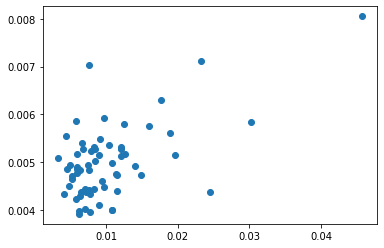

In [335]:
###retd is correlated to both returns and variance in a period

x = ls_div_to_div_std
y = ls_div_ret
plt.scatter(x, y)

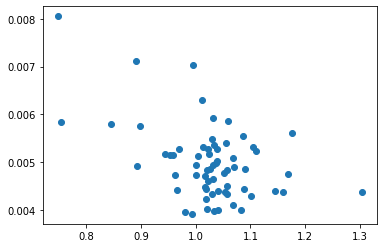

In [351]:
x = ls_div_to_div_ret
y = ls_div_ret
plt.scatter(x, y)

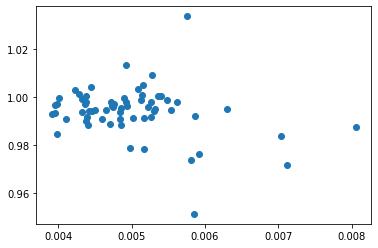

In [345]:
###Price the day of a return is very slightly correlated to the dividend price, but has a loss on average.

plt.scatter(np.array(d[d['SPY']['retd'] != 0]['SPY']['retd']), np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']))

In [355]:
np.corrcoef(np.array(d[d['SPY']['retd'] != 0]['SPY']['retd']), np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']))

array([[ 1.        , -0.25238551],
       [-0.25238551,  1.        ]])

In [353]:
d[d['SPY']['retd'] != 0]['SPY']['retx'].mean()

0.9942439051728797

In [348]:
np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']).std()

0.01044219807136065

In [208]:
s_ls_div = []
t_ls_div = []
s_div_cnt = 1
t_div_cnt = 1
for x in d.iterrows():
    if x[1]['SPY']['retd'] == 0:
        s_div_cnt += 1
    else:
        s_ls_div.append(s_div_cnt)
        s_div_cnt = 1
    if x[1]['TLT']['retd'] == 0:
        t_div_cnt += 1
    else:
        t_ls_div.append(t_div_cnt)
        t_div_cnt = 1    

In [119]:
s_ls_div_dt = []
t_ls_div_dt = []
s_div_cnt = 0
t_div_cnt = 0
for x in d.iterrows():
    if x[1]['SPY']['retd'] != 0:
        s_ls_div_dt.append(x[0])
    if x[1]['TLT']['retd'] != 0:
        t_ls_div_dt.append(x[0])


In [436]:
###This is to get the dividends to create a model for predicting/simulating retd

div_day_cumsum = np.cumsum(s_ls_div)
start = 1
cumret = 0
ls_div_to_div_ret = []
ls_div_ret = []
ls_div_to_div_std = []

for x in div_day_cumsum:
    div_to_div_std = np.std((np.array(d.iloc[start-1:x-1]['SPY']['ret'])))
    div_to_div_ret = (np.array(d.iloc[start-1:x-1]['SPY']['ret'])).prod()
    spy_div = (d.iloc[x-1]['SPY']['retd'])
    ls_div_to_div_std.append(div_to_div_std)
    ls_div_to_div_ret.append(div_to_div_ret)
    ls_div_ret.append(spy_div)
    start=x
    
X = np.array([ls_div_to_div_ret,ls_div_to_div_std]).T
y=ls_div_ret
reg = LinearRegression().fit(X,y)

In [577]:
###This simulates the retx, and uses that simulate price and dividend.



retx_sim = d[d['SPY']['retd'] == 0]['SPY']['retx']
retx_sim_mod = CircularBlockBootstrap(20, retx_sim)
tot_sim = 10
sim = np.zeros((4035, 3, tot_sim))
count = 0
for y in retx_sim_mod.bootstrap(tot_sim):
    test = y[0][0]



    div_day_cumsum = np.cumsum(s_ls_div)
    start = 1
    ls_of_div = np.array(d[d['SPY']['retd'] != 0]['SPY']['retd'])
    ls_of_div_retx = np.array(d[d['SPY']['retd'] != 0]['SPY']['retx'])

    ls_sim_div = []

    test.index = retx_sim.index
    for x in range(len(div_day_cumsum)):
        cum_retx = np.array(test[start-1:div_day_cumsum[x]-1]).prod()
        cum_std = np.array(test[start-1:div_day_cumsum[x]-1]).std()
        pred_div = reg.predict(np.array([[cum_retx],[cum_std]]).T)
        sim_div_idx = min(ls_of_div, key=lambda i:abs(i-pred_div))
        sim_rx = ls_of_div_retx[np.where(ls_of_div==sim_div_idx)[0][0]]
        test.loc[s_ls_div_dt[x]] = sim_rx
        ls_sim_div.append(pred_div[0])
        test = test.sort_index()
        start=div_day_cumsum[x]

    test[0] = 1
    prc[0] = d.SPY.prc[0]
    prc[1:] = test[1:].cumprod() * prc[0]



    div_pay = test*0
    div_dic = dict(zip(s_ls_div_dt, ls_sim_div)) 
    for i in s_ls_div_dt:
        div_pay[i] = div_dic[i]

    sim[:,:,count] = np.array([prc,test,div_pay]).T
    count +=1
    
    
